## Library  PyDLM - https://pydlm.github.io/index.html
## method - Bayesian Structural Time Series
## forecast - this is inverval variation series (it will be green corridor on the plot)

### Based on Search Ads
### Conversions = Payments

### Calculate intervals using only actual year or the year before if it is Q1 right now: world changes very quickly, we could not tell that actual year is like the year before by no means.

EN:
When you working with Digital Agency, you should measure its results not only by absolute numbers, but through invervals. Yes, it is like A/B-test, where B - resutls of Agency itself, and A - in-house marketers. But wait! How can it be done? Do we have to make our A-part in alternative Universe? No, we have Bayesian Structural Time Series for this to predict our performance (inverval of it by day) on next few months and compare it with results of Agency. If there is stat. significance we could tell that, yes, Agency shows real results that differs from ours: in other words, they do it more profecionally and are worth the money. But if not, we could say "Goodbye" to them based on math.
You will see in the end of the book two 'corridors': green is expected conversions (where they flow) and red one - efficiency.

RU:
Работа с агентством это по сути A/B-тест, где B - это усилия , а А - наши. Результаты агентства надо оценивать не столько по абсолютным значениям, сколько через интервалы. Наши платежи в рамках него и двигаются, поэтому имеет значение именно смещение интервала, где были бы значимые отличия в средних. Поэтому и успех надо оценивать через смещение, то есть наличие или отсутствие стат. значимости в платежах (базовая метрика эффективности). 

Но мы не можем выступать стороной А в силу очевидных причин (для этого нужна параллельная Вселенная). Поэтому стороной А будет прогноз нашего интервала с ноября месяца.

### This model could be upgraded by such correction as if a day is working day or holiday;

In [ ]:
#auth to get data from BQ
#from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
#launch_browser = True
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

#appflow = flow.InstalledAppFlow.from_client_secrets_file( 'PUT YOURS!!!', scopes=['https://www.googleapis.com/auth/bigquery'])

#Dont uncomment until you use local_server
#if launch_browser:
    #appflow.run_local_server()

#appflow.run_console()

#credentials = appflow.credentials

In [ ]:
#it can help.
#!pip install pydlm
#!pip install google-cloud-bigquery

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics
from datetime import datetime
from google.cloud import bigquery
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.linear_model import LinearRegression
from scipy import stats
from math import sqrt

#IF YOU USE BQ, USE THIS CODE
#project = 'YOUR PROJECT'
#client = bigquery.Client(project=project, credentials=credentials)

In [7]:
payments_and_costs_till_november_2019 = pd.read_excel('YOUR-PATH/payments_and_costs_till_november_2019.xls')


In [8]:
#BQ
#reg_training_data = client.query(payments_and_costs_till_november_2019).to_dataframe()

#CSV
reg_training_data = payments_and_costs_till_november_2019
#we know, for example, that if 100k$ gives us 10k conversions, 1 mln.$ won't give us 100k. It will give us about 85k.
#it is inflation
inflation = reg_training_data.sort_values(by=['costs'])
inflation = inflation.reset_index()
inflation = inflation.drop(columns=['index'])
inflation['cac'] = round(inflation['costs']/inflation['payments'], 2)
inflation['base'] = inflation['cac'][0]
inflation['inflation_gross'] = round(((inflation['cac'] - inflation['base'])/inflation['cac'])*100, 2)
inflation = inflation.sort_values(by=['cac'])
inflation = inflation.reset_index()
inflation = inflation.drop(columns=['index'])
inflation['inflation_gross_median'] = round(inflation['inflation_gross'].median(), 2)
median_inflation = inflation['inflation_gross_median'][0]
query = (inflation['inflation_gross'] > median_inflation - 3) & (inflation['inflation_gross'] < median_inflation + 3)
close_to_median_costs = inflation['costs'].loc[query]
close_to_median_costs = close_to_median_costs.reset_index()
close_to_median_costs = close_to_median_costs.drop(columns=['index'])
close_to_median_costs_mean = close_to_median_costs['costs'].mean()
#inflation of each extra dollar
dollar_inflation = median_inflation/close_to_median_costs_mean

In [9]:
X = np.array(reg_training_data['costs'])
X = X.reshape(-1, 1)
y = np.array(reg_training_data['payments'])

regressor = LinearRegression()
regressor.fit(X, y)

#budget/payments rate
dymanic_of_payments = round(regressor.coef_[0], 5)

#Forecast was made in october 2019. So, november, december and Q1 of 2020 were future.
#That is why budget (costs) are fixed numbers: they are based on given budget on these months.
#november , december, january, february, march
costs_since_november_2019 = np.array([650000, 700000,  750000,  700000, 750000])
costs_since_november_2019 = costs_since_november_2019.reshape(-1, 1)

october_costs_2019 = int(reg_training_data['costs'].iloc[-2:-1])
october_payments_2019 = int(reg_training_data['payments'].iloc[-2:-1])

budget_diff = costs_since_november_2019 - october_costs_2019
payments_by_budget_diff = budget_diff * dymanic_of_payments
payments_by_budget_diff_percent = payments_by_budget_diff / october_payments_2019
budget_inflation = budget_diff * dollar_inflation / 100

In [10]:
#data since 1 Jan 2017
#Search

#by day
query_till_november_2019 = pd.read_excel('YOUR-PATH/query_till_november_2019.xls')

#by day
query_since_november_2019 = pd.read_excel('YOUR-PATH/query_since_november_2019.xls')

#by month
query_till_november_2019_monthly = pd.read_excel('YOUR-PATH/query_till_november_2019_monthly.xls')

#by month
query_since_september_2019_monthly = pd.read_excel('YOUR-PATHr/query_since_september_2019_monthly.xls')

In [11]:
#pandas object
#history data for fit
#BQ
#training_data = client.query(query_till_november_2019).to_dataframe()

#Excel
training_data = query_till_november_2019

#order by
training_data = training_data.sort_values(by=['click_date'])
training_data = training_data.reset_index(drop=True)

#calculate, using 2019 year since summer (in this modified case it is crucial!!!)
#In our case we needed 2017 and 2018 years as well
training_data = training_data[training_data['click_date'] > 20190430]

In [12]:
features = []
for x in training_data['click_date']:
    x=[x]
    features.append(x)

In [13]:
#payments
payments = list(training_data['payments'])

#training of DLM
payments_DLM = dlm(payments)
payments_DLM = payments_DLM + dynamic(features=features, discount=0.98, name='date', w=10.0)
payments_DLM.evolveMode('independent')
payments_DLM.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [14]:
#you could use datetime library to make it automatically
months_dict = {'november': 30, 'december': 31, 'january': 31, 'february': 29, 'march': 31}
days = 0
for x in months_dict:
    days = days + months_dict[x]

In [15]:
datelist = pd.date_range(start='2019-11-01', periods=days).tolist()
datelist = pd.to_datetime(datelist)
new_datelist = []
for x in datelist:
    x = str(x)
    x = x[:10]
    x = x.replace("-", "")
    new_datelist.append(x)

In [16]:
newData = {'date': [[x] for x in new_datelist]}
#myDLM.predictN(N=len(df_actual)-5, featureDict=newData)

In [32]:
#model gives us invervals of our conversion, - payments, - by day.
#these would be our outcome (number of payments; by inverval) by day if we didn't work with agency
predictions, varience = payments_DLM.predictN(N=len(new_datelist), featureDict=newData)
predictions_dataframe = pd.DataFrame(list(predictions))
mean_predictions = predictions_dataframe.mean()

In [33]:
#BQ
#payments_montly_past = client.query(query_till_november_2019_monthly).to_dataframe()

#Excel
payments_montly_past = query_till_november_2019_monthly

payments_montly_past = payments_montly_past.sort_values(by=['click_date'])

dates = []
for x in payments_montly_past['click_date']:
    date = datetime.strptime(str(x), "%Y%m")
    dates.append(date)
    
payments_montly_past.index = pd.to_datetime(dates)

In [34]:
seasons = payments_montly_past.drop(columns=['click_date'])
season_2017 = seasons.loc['2017-01-01' : '2017-12-01']
mean_payments_2017 = season_2017['payments'].mean()
coef_season_2017 = season_2017/mean_payments_2017
coef_season_2017 = coef_season_2017.rename(columns={'payments': 'coef_s_17'})
coef_season_2017 = coef_season_2017.reset_index(drop=True)

season_2018 = seasons.loc['2018-01-01' : '2018-12-01']
mean_payments_2018 = season_2018['payments'].mean()
coef_season_2018 = season_2018/mean_payments_2018
coef_season_2018 = coef_season_2018.rename(columns={'payments': 'coef_s_18'})
coef_season_2018 = coef_season_2018.reset_index(drop=True)

coef_seasons = coef_season_2018.join(coef_season_2017)
coef_mean = {'coef': coef_seasons.mean(axis=1)}
coef_mean = pd.DataFrame(coef_mean)
#november, december, january, february, march
coef_mean_correstions = [coef_mean['coef'][10], coef_mean['coef'][11], coef_mean['coef'][0], coef_mean['coef'][1], coef_mean['coef'][2]]
coef_mean_correstions = [[i-1] for i in coef_mean_correstions]

In [35]:
#BQ
#payments_montly_actual = client.query(query_since_september_2019_monthly).to_dataframe()

#Excel
payments_montly_actual = query_since_september_2019_monthly
payments_montly_actual = payments_montly_actual.sort_values(by=['click_date'])

dates = [] 
for x in payments_montly_actual['click_date']: 
    date = datetime.strptime(str(x), "%Y%m") 
    dates.append(date)

payments_montly_actual.index = pd.to_datetime(dates) 
payments_montly_actual = payments_montly_actual.drop(payments_montly_actual.index[0])

In [36]:
if (stats.shapiro(training_data['payments'])[1] < 0.05):
    print('Payments of our company since 1 january 2017 are distributed normally')

Payments of our company since 1 january 2017 are distributed normally


In [43]:
#EN:
#code logic
#we generate "y" sample, len = number of days in month
#example: for november - 30 elements cos of 30 days. 1 element - conversion (payment) by 1 november
#"y" sample has normal distribution, with Mu = mean of DLM-model and Sigma based on payments since 1 January of 2017
#+seasonality
#+budget (growth or reduction)
#+dollar's inflation (to take into account Search's capacity)

#after that we generate "z" sample with Mu > Mu of "y" by increment=0.000001
#so we have sample that elements with slightly bigger values (lim -> efficiency)
#+seasonality
#+budget (growth or reduction)
#+dollar's inflation (to take into account Search's capacity)

#by t-test we compary these samples. If there are no stat. significance (with alpha = 0.05) or effect size < 0.2
#we generate new "z" with Mu = Mu_prev_z + increment

#we do it until we get stat. sign. and size effect 

#but we make number of trials for each month, because we think probabilistically: we could get from "a" to "b"
#[a, b] number of conversions each day and as a result - each month too.

#RU:
#логика кода
#для каждого месяца создается выборка y из элементов объемом = кол-ву дней в месяце
#пример: для ноября - 30 элементов так как 30 дней; 1-ый элемент - это кол-во плажетей за 1 ноября
#выборка создается на базе нормального распределения, со средним взятым из спрогнозированного DLM модели 
#и стандартным отклонением на базе плажетей по дням с 1 января 2017 по 31 октября 2019
#+корректировка на сезонность (подсчитана традиционным для экономики способом)
#+корректировка на бюджет (увеличение или уменьшение)
#+корректировка на инфляцию каждого доллара сверху (для учета емкости выкупания поиска)

#после создается распределение z со смещенным средним, где среднее z > среднего y на increment=0.000001
#так распределение смещается в пользу бОльших значений (=эффективность)
#+корректировка на сезонность (подсчитана традиционным для экономики способом)
#+корректировка на бюджет (увеличение или уменьшение)
#+корректировка на инфляцию каждого доллара сверху (для учета емкости выкупания поиска)

#путем t-test'a идет сравнение. Если отличий нет или effect size меньше 0.2 ("малый эффект"), создается новая выборка z с 
#среднем + increment

#и так до тех пор, пока не будет отличий и effect size

#но так как в каждом месяце может выходить всегда по-разному сумма плажетей, то делается серия испытаний для каждого месяца
#что дает нам диапазон как для предсказанных платежей в месяц, так и диапазон тех платежей (выборок z), которые мы бы сочли
#за эффективность работы агентства 

#Cohen's d; for size effect
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1), np.var(d2)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

#prediction
#5 rows for 5 months
#it will be great if you could make initiation by number of months automatically, if, say, there are 6 months.
y_2d = [[], [], [], [], []]

#effectiveness
z_2d = [[], [], [], [], []]

#trials
#the more is better, but takes more time
trials = 300
trial_number = 0

while(True):
    for x in enumerate(months_dict):
        mu = mean_predictions[0]
        sigma = training_data['payments'].std()
        budget_percent = float(payments_by_budget_diff_percent[x[0]])
        budget_inflation_percent = float(budget_inflation[x[0]])
        season = coef_mean_correstions[x[0]][0]
        
        shapiro = 0.01
        while(shapiro < 0.05):
            y_monthly = np.random.normal(mu, sigma, size=months_dict[x[1]])
            y_monthly = np.array([int(i*0) if i < 0 else int(i) for i in y_monthly])
            shapiro = stats.shapiro(y_monthly)[1]
            
        #correction by budget, inflation, seasonality
        if(budget_inflation_percent > 0):
            y_monthly = [i+i*budget_percent+i*season-i*budget_inflation_percent for i in y_monthly]
        else:
            y_monthly = [i+i*budget_percent+i*season+i*budget_inflation_percent for i in y_monthly]
            
        y_monthly = [int(i) for i in y_monthly]

        alpha = 0.05
        pvalue = 0.06
        increment = 0.000001
        mu = mu+increment
        small_effect_size = 0.2
        effect_size = 0
        while (pvalue > alpha or effect_size < small_effect_size):
            shapiro = 0.01
            while(shapiro < 0.05):
                z_monthly = np.random.normal(mu, sigma, size=months_dict[x[1]])
                z_monthly = np.array([int(i*0) if i < 0 else int(i) for i in z_monthly])
                shapiro = stats.shapiro(z_monthly)[1]
            
            #correction by budget, inflation, seasonality
            if(budget_inflation_percent > 0):
                z_monthly = [i+i*budget_percent+i*season-i*budget_inflation_percent for i in z_monthly]
            else:
                z_monthly = [i+i*budget_percent+i*season+i*budget_inflation_percent for i in z_monthly]
            z_monthly = [int(i) for i in z_monthly]
            results = stats.ttest_ind(y_monthly, z_monthly)
            pvalue = results[1]
            effect_size = cohend(z_monthly, y_monthly)
            mu = mu+increment
            increment = increment + 0.000001
        y_2d[x[0]].append(sum(y_monthly))
        z_2d[x[0]].append(sum(z_monthly))
        
    trial_number = trial_number + 1
    if(trial_number == trials):
        break
    
#2d to 1d
y = []
for x in enumerate(y_2d):
    mean = int(statistics.mean(y_2d[x[0]]))
    y.append(mean)
    
z = []
for x in enumerate(z_2d):
    mean = int(statistics.mean(z_2d[x[0]]))
    z.append(mean)

In [44]:
#Now wait :>
#for intervals
errors_of_predicted = []
low_border_predicted = []
high_border_predicted = []
for x in enumerate(y_2d):
    dispersion = max(x[1]) - min(x[1])
    error = int(dispersion/2)
    errors_of_predicted.append(error)
    
    mean = int(statistics.mean(y_2d[x[0]]))
    low_border_predicted.append(mean - error)
    high_border_predicted.append(mean + error)
    
#for intervals    
errors_of_effectiveness = []
low_border_effectiveness = []
high_border_effectiveness = []
for x in enumerate(z_2d):
    dispersion = max(x[1]) - min(x[1])
    error = int(dispersion/2)
    errors_of_effectiveness.append(error)
    
    mean = int(statistics.mean(z_2d[x[0]]))
    low_border_effectiveness.append(mean - error)
    high_border_effectiveness.append(mean + error)

In [45]:
dates_to_add = []
for x in new_datelist:
    date = datetime.strptime(str(x), "%Y%m%d")
    dates_to_add.append(date)

In [46]:
def unique(list1): 
    unique_list = [] 
    for x in list1: 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

def convert_to_month(dates, data):
    data = {'payments': data}
    
    new_index_list = []
    for x in new_datelist:
        year_month = x[:6]
        year_month = datetime.strptime(str(year_month), "%Y%m")
        new_index_list.append(year_month)
    new_index_list = unique(new_index_list)
    
    dataframe = pd.DataFrame(index=new_index_list, data=data)
    return dataframe


predicted = convert_to_month(dates_to_add, y)
low_predicted = convert_to_month(dates_to_add, low_border_predicted)
high_predicted = convert_to_month(dates_to_add, high_border_predicted)


effectiveness = convert_to_month(dates_to_add, z)
low_effectiveness = convert_to_month(dates_to_add, low_border_effectiveness)
high_effectiveness = convert_to_month(dates_to_add, high_border_effectiveness)

In [47]:
#for plot's annotation
all_payments = pd.DataFrame()
all_payments = all_payments.append(payments_montly_past, sort=True)
all_payments = all_payments.append(payments_montly_actual, sort=True)
all_payments = all_payments.append(predicted, sort=True)
all_payments = all_payments.append(low_predicted, sort=True)
all_payments = all_payments.append(high_predicted, sort=True)
all_payments = all_payments.append(effectiveness, sort=True)
for x in enumerate(all_payments['click_date']):
    if np.isnan(x[1]):
        date = str(all_payments.index[x[0]])
        date = int(date[:7].replace('-', ''))
        all_payments.iloc[x[0], 0] = date

<IPython.core.display.Javascript object>


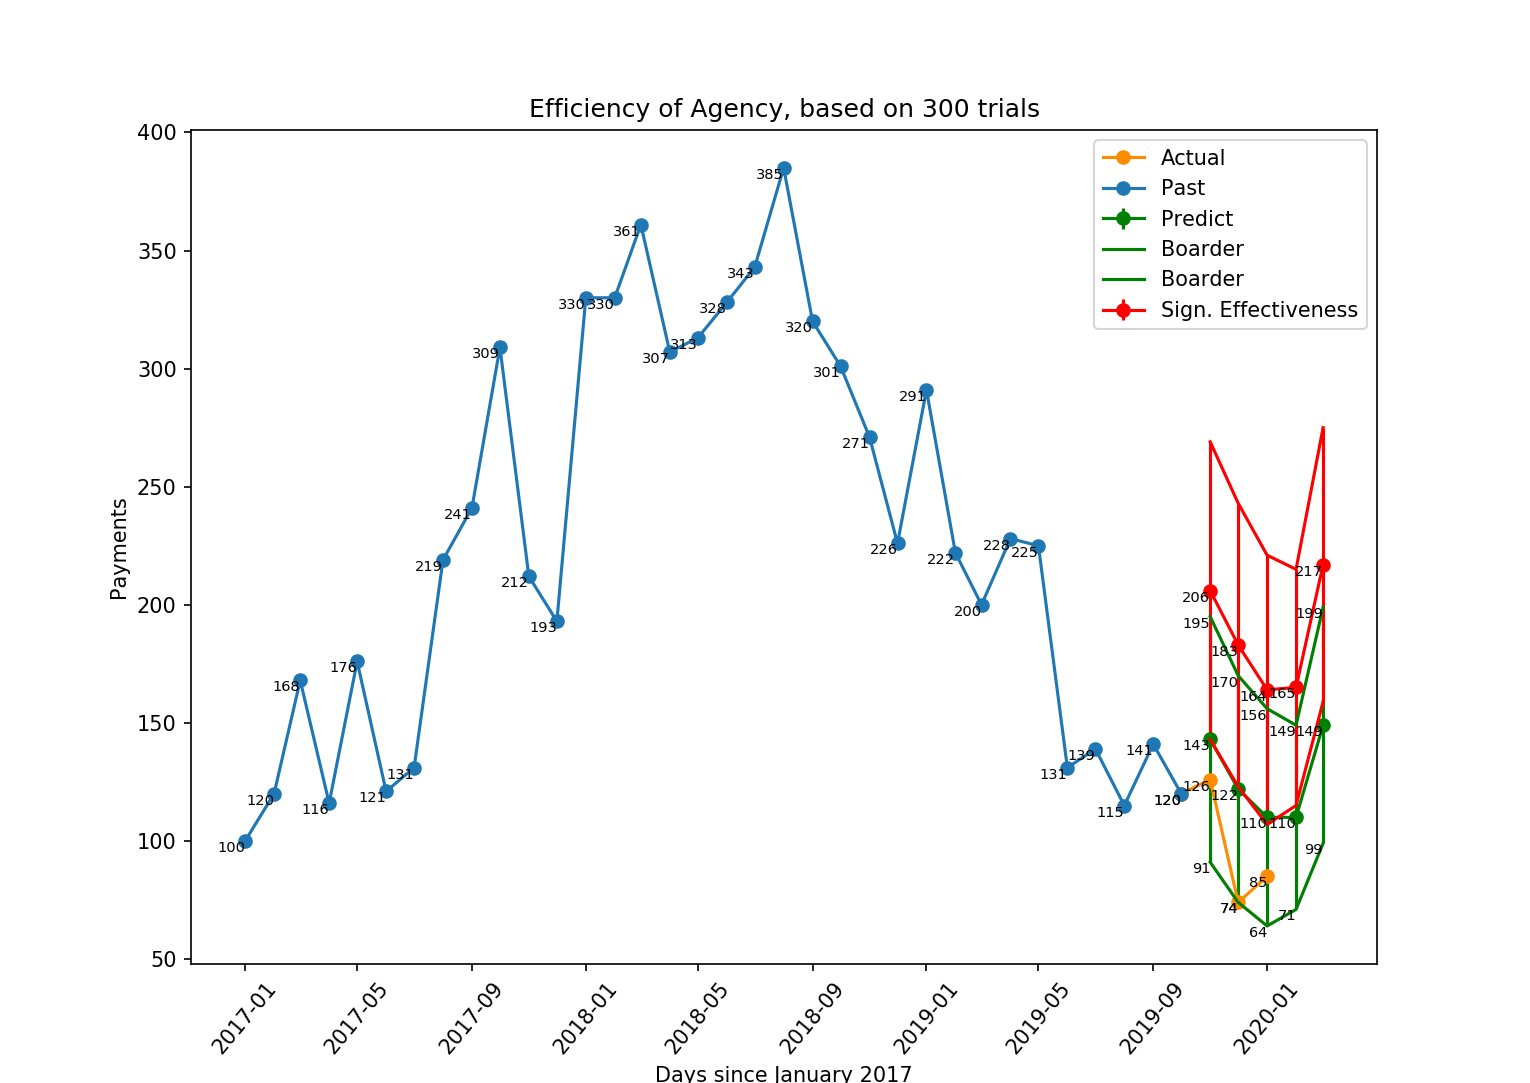

In [48]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

fig, ax = plt.subplots()

actual = plt.errorbar(payments_montly_actual.index, payments_montly_actual['payments'], color='darkorange', marker='o')
past = plt.errorbar(payments_montly_past.index, payments_montly_past['payments'], marker='o')


#predict
predict = plt.errorbar(predicted.index, predicted['payments'], yerr = errors_of_predicted, color='g', marker='o')
high_p = plt.errorbar(high_predicted.index, high_predicted['payments'], color='g')
low_p = plt.errorbar(low_predicted.index, low_predicted['payments'], color='g')

#effect
effect = plt.errorbar(effectiveness.index, effectiveness['payments'], yerr = errors_of_effectiveness, color='r', marker='o')
high_e = plt.errorbar(low_effectiveness.index, low_effectiveness['payments'], color='r')
low_e = plt.errorbar(high_effectiveness.index, high_effectiveness['payments'], color='r')

#notation
for i in enumerate(all_payments['click_date']):
    ax.annotate(s=str(all_payments['payments'][i[0]]), xy=(all_payments.index[i[0]], all_payments['payments'][i[0]]), 
                horizontalalignment='right', verticalalignment='top', rotation=0, size=7)
    
ax.set_title('Efficiency of Agency, based on ' + str(trials) + ' trials')
ax.set_xlabel('Days since January 2017')
ax.set_ylabel('Payments')
ax.legend(['Actual', 'Past', 'Predict', 'Boarder', 'Boarder', 'Sign. Effectiveness'])
plt.xticks(rotation=50)
plt.show()